<a href="https://colab.research.google.com/github/rainaa0277/Sentiment-Analysis-using-Recurring-Neural-Network/blob/main/Sentiment_Analysis_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sentiment Analysis Using RNN**

In [182]:
#Importing Tensor flow version 2.4.1
import tensorflow as tf
# !pip install Tensorflow==2.4.1
print(tf.__version__)

2.4.1


**STEP1: Importing necessary libraries**

In [183]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
import itertools
import os

In [184]:
# importing and mounting the drive
from google.colab import drive

In [185]:
#changing the directory
os.chdir("/content/drive/MyDrive/Deep Learning/RNN Exam/Datasets")

In [186]:
# Checking the current directory
!dir

tweets_test.csv  tweets_train.csv


**STEP2 - LOAD THE DATASET FROM DIRECTORY**

In [187]:
df = pd.read_csv("tweets_train.csv")
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source,is_retweet,clean_text,Sentiment
0,Romy 👑,Bolton - England,"Tables turn, bridges burn, you live and learn.",2009-06-15 09:00:39,525,896,3854,False,2020-09-19 15:19:32,['TheSocialDilemma'],Twitter for Android,False,TheSocialDilemma is an eye opener isn t it ple...,Neutral
1,TLynn Peterson,"Black Canyon City, Arizona",Acquired disability ♿ after an accident. Livin...,2013-05-29 00:17:46,5045,5374,48152,False,2020-09-13 00:31:46,['TheSocialDilemma'],Twitter for Android,False,TheSocialDilemma If we don t agree on what is ...,Positive
2,Rutger Kosters,Netherlands,Cloud Solution Architect @NetApp | VCDX #209 |...,2014-10-07 09:34:10,574,251,1070,False,2020-09-09 21:10:33,['TheSocialDilemma'],Twitter for Android,False,Watching TheSocialDilemma scary to see social ...,Negative
3,IDFWU🗯🇿🇼🇿🇦,"East London, South Africa","YOU HAVE OPTIONS, YOU CAN’T JUST TAKE WHAT LIF...",2012-08-22 11:09:06,706,618,1320,False,2020-09-11 04:33:08,NaN,Twitter for Android,False,You check your social media before you pee in ...,Positive
4,Treebel,NaN,NaN,2010-09-25 07:25:31,9,13,55,False,2020-09-17 16:27:38,['thesocialdilemma'],Twitter for iPhone,False,watch thesocialdilemma and see what s actually...,Negative


In [188]:
#Shape of the dataset
df.shape

(17000, 14)

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         16999 non-null  object
 1   user_location     13393 non-null  object
 2   user_description  15838 non-null  object
 3   user_created      17000 non-null  object
 4   user_followers    17000 non-null  int64 
 5   user_friends      17000 non-null  int64 
 6   user_favourites   17000 non-null  int64 
 7   user_verified     17000 non-null  bool  
 8   date              17000 non-null  object
 9   hashtags          13351 non-null  object
 10  source            17000 non-null  object
 11  is_retweet        17000 non-null  bool  
 12  clean_text        16992 non-null  object
 13  Sentiment         17000 non-null  object
dtypes: bool(2), int64(3), object(9)
memory usage: 1.6+ MB


**STEP3 - DATA PREPROCESSING**

In [190]:
data = df[["clean_text", "Sentiment"]]
data.head()

,clean_text,Sentiment
0,TheSocialDilemma is an eye opener isn t it ple...,Neutral
1,TheSocialDilemma If we don t agree on what is ...,Positive
2,Watching TheSocialDilemma scary to see social ...,Negative
3,You check your social media before you pee in ...,Positive
4,watch thesocialdilemma and see what s actually...,Negative


In [191]:
data.shape

(17000, 2)

In [192]:
#Checking for null values
data.isna().sum()

clean_text    8
Sentiment     0
dtype: int64

In [193]:
#Drop the null values
data = data.dropna()
data.shape

(16992, 2)

In [194]:
#Taking a sample tweet and checking the label assigned to that sample
print("Tweet :",data["clean_text"][12])
print("Sentiment :",data["Sentiment"][12])

Tweet : I recommend everyone go watch TheSocialDilemma on Netflix It s an eye opener
Sentiment : Neutral


In [195]:
#Label encoding
labels = {"Negative":0,"Positive":1,"Neutral":2}
data["Target"] = data["Sentiment"].map(labels)
data.head()

,clean_text,Sentiment,Target
0,TheSocialDilemma is an eye opener isn t it ple...,Neutral,2
1,TheSocialDilemma If we don t agree on what is ...,Positive,1
2,Watching TheSocialDilemma scary to see social ...,Negative,0
3,You check your social media before you pee in ...,Positive,1
4,watch thesocialdilemma and see what s actually...,Negative,0


In [196]:
#Creating a new dataset with 2 columns
df_train = data[["clean_text", "Target"]]
df_train.head()

,clean_text,Target
0,TheSocialDilemma is an eye opener isn t it ple...,2
1,TheSocialDilemma If we don t agree on what is ...,1
2,Watching TheSocialDilemma scary to see social ...,0
3,You check your social media before you pee in ...,1
4,watch thesocialdilemma and see what s actually...,0


In [197]:
#Checking the shape
df_train.shape

(16992, 2)

In [198]:
#Splitting the data into train and test for predictions
df_training = df_train.iloc[:13000]
df_testing = df_train.iloc[13000:]

In [199]:
#Checking shape of the training and testing data
print(df_training.shape)
print(df_testing.shape)

(13000, 2)
(3992, 2)


**STEP4 - DATA VISUALIZATION**

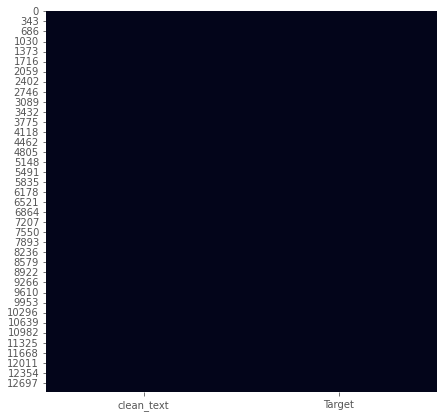

In [200]:
#There are no null values available in the dataset
plt.figure(figsize=(7,7))
sns.heatmap(data=df_training.isna(), cbar=False)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


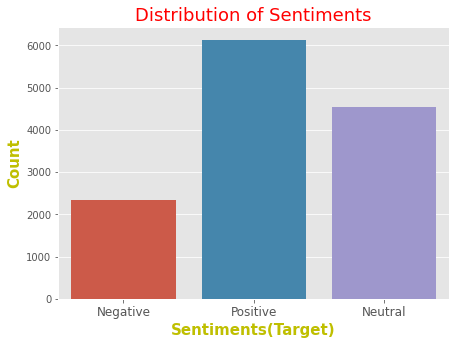

Negative % = 18.03
Positive % = 47.13
Neutral % = 34.84


In [201]:
#Checking for the distribution of the sentiments
plt.figure(figsize=(7,5))
sns.countplot(df_training["Target"])
plt.xticks([0,1,2],["Negative", "Positive", "Neutral"], fontsize=12)
plt.xlabel("Sentiments(Target)", fontweight="bold", fontsize=15, color="y")
plt.ylabel("Count",fontweight="bold", fontsize=15, color="y")
plt.title("Distribution of Sentiments", fontsize=18, color="r")
plt.show()

#Calculating the percentage of the 3 categories
Negative = round(df_training["Target"].value_counts()[0]/len(df_training) * 100, 2)
Positive = round(df_training["Target"].value_counts()[1]/len(df_training) * 100, 2)
Neutral  = round(df_training["Target"].value_counts()[2]/len(df_training) * 100, 2)

#Print the percentages 
print("Negative % =", Negative)
print("Positive % =", Positive)
print("Neutral % =", Neutral)

In [202]:
#Converting the train dataset into tensorflow dataset format for faster execution:

dataset = (tf.data.Dataset.from_tensor_slices(
    (
        tf.cast(df_training["clean_text"].values, tf.string),
        tf.cast(df_training["Target"].values, tf.int32)
    )
                                             )
          )
print(dataset)

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>


In [203]:
# print first five record from train dataset
for example, sentiment in dataset.take(5):
    print("--"*75)
    print("example : ", example.numpy())
    print()
    print("sentiment: ", sentiment.numpy())

------------------------------------------------------------------------------------------------------------------------------------------------------
example :  b'TheSocialDilemma is an eye opener isn t it please ignore the irony of me tweeting about it'

sentiment:  2
------------------------------------------------------------------------------------------------------------------------------------------------------
example :  b'TheSocialDilemma If we don t agree on what is true or that there is such a thing as truth we re toast This is'

sentiment:  1
------------------------------------------------------------------------------------------------------------------------------------------------------
example :  b'Watching TheSocialDilemma scary to see social media is fucking up the mental health of Gen X'

sentiment:  0
------------------------------------------------------------------------------------------------------------------------------------------------------
example :  b'Yo

In [204]:
buffer_size = 10000
batch_size = 64

# create batches of the dataset

dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# now every batch will have 64 samples

In [205]:
# print first batch from train dataset

for example, sentiment in dataset.take(1):
    print("Example : ", example.numpy())
    print("-----------------------")
    print("Sentiment: ", sentiment.numpy())
    print("-----------------------")
    print("Total Length: ", len(sentiment.numpy()))

Example :  [b'Has anyone watched The Social Dilemma Thoughts Literally tempted to write a blog post about this TheSocialDilemma'
 b'TheSocialDilemma has to be the scariest movie of 2020'
 b'TheSocialDilemma highly recommended show documentry from Netflix totally scary'
 b'Social media starts to dig deeper and deeper into the brain stem and takes over sense of self worth and identity TheSocialDilemma'
 b'Is there not an onus on us as society to not be so easily manipulated TheSocialDilemma'
 b'TheSocialDilemma also showed that our president is able to get support amp attention via news media channels amp socia'
 b'Amazing doc on Netflix TheSocialDilemma ironically I headed to Twitter straight after but go watch it Also me'
 b'30 I wish they could bring it in our regional languages as well coz majority of'
 b'Spent my Afternoon watching TheSocialDilemma amp The Portrayed Future is Scary not because of AI Controlling Use'
 b'Holy shxt that search engine predictions are different from oppo

In [206]:
# create validation dataset
validation_dataset = dataset.take(70) 
train_dataset = dataset.skip(70)

# First 100 batch from dataset for validation data
# Each bath will contain 64 samples(Batch_size = 64 defined above)
# Skip first 100 batches from dataset and create a new train_dataset

In [207]:
# Create the layer, and pass the dataset text to the layer
token_size = 1200
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=token_size)
encoder.adapt(train_dataset.map(lambda text, Target: text))

In [208]:
# create vocabulary of words
vocabulary = np.array(encoder.get_vocabulary())

# print top 30 vocabulary
vocabulary[0:30]

array(['', '[UNK]', 'thesocialdilemma', 'the', 'i', 'to', 'on', 'and',
       'you', 'a', 'it', 'is', 'social', 'watch', 'of', 'netflix', 's',
       'this', 'that', 'in', 'media', 'are', 'for', 'we', 'watching', 't',
       'if', 'watched', 'about', 'my'], dtype='<U17')

In [209]:
#Checking the length of the vocabulary
len(vocabulary)

1200

In [210]:
#Checking a sample example and this will give is the index of the alphabets
encoded_example = encoder("i can do this on netflix").numpy()

In [211]:
#Index of the alphabets in the statement above
encoded_example

array([ 4, 63, 49, 17,  6, 15])

**STEP4 - Defining your RNN model architecture**

In [212]:
# Create RNN model
rnn = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation="relu"),
    #Using softmax due to 3 labels in the output(Multiclass classification)
    tf.keras.layers.Dense(3, activation="softmax")])

**STEP5 - Compiling your RNN model**

In [213]:
# compile the model

# For multiclass classification:
back_propagation = rnn.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(0.0001),metrics=['accuracy'])

**STEP6 - Training your model on your training data**

In [235]:
rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 64)          76800     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 89,411
Trainable params: 89,411
Non-trainable params: 0
_________________________________________________________________


In [214]:
#Fit the model and tracking the loss and validation accuracy
EPOCHS = 50

result = rnn.fit(train_dataset, epochs=EPOCHS, validation_data = validation_dataset)

Epoch 1/50
134/134 [==============================] - 4s 21ms/step - loss: 1.0682 - accuracy: 0.4110 - val_loss: 0.9800 - val_accuracy: 0.5643
Epoch 2/50
134/134 [==============================] - 3s 19ms/step - loss: 0.9652 - accuracy: 0.5803 - val_loss: 0.8407 - val_accuracy: 0.6509
Epoch 3/50
134/134 [==============================] - 3s 19ms/step - loss: 0.8261 - accuracy: 0.6579 - val_loss: 0.7327 - val_accuracy: 0.6951
Epoch 4/50
134/134 [==============================] - 2s 18ms/step - loss: 0.7066 - accuracy: 0.7198 - val_loss: 0.6275 - val_accuracy: 0.7647
Epoch 5/50
134/134 [==============================] - 2s 18ms/step - loss: 0.6043 - accuracy: 0.7754 - val_loss: 0.5447 - val_accuracy: 0.8049
Epoch 6/50
134/134 [==============================] - 3s 19ms/step - loss: 0.5277 - accuracy: 0.8089 - val_loss: 0.4868 - val_accuracy: 0.8241
Epoch 7/50
134/134 [==============================] - 3s 19ms/step - loss: 0.4821 - accuracy: 0.8279 - val_loss: 0.4293 - val_accuracy: 0.8554

**STEP7 - EVALUATING MODEL ON UNSEEN DATA**

In [215]:
y_pred = rnn.predict(df_testing["clean_text"])
y_pred

array([[1.9064602e-02, 5.0939310e-02, 9.2999601e-01],
       [1.3136940e-05, 9.9998689e-01, 3.2108030e-08],
       [1.0406479e-04, 3.1447451e-04, 9.9958152e-01],
       ...,
       [8.5914861e-03, 5.3972844e-03, 9.8601127e-01],
       [3.6802667e-05, 9.9996257e-01, 5.5158375e-07],
       [1.7257351e-02, 1.5667806e-03, 9.8117584e-01]], dtype=float32)

In [216]:
y_pred[:10]

array([[1.9064602e-02, 5.0939310e-02, 9.2999601e-01],
       [1.3136940e-05, 9.9998689e-01, 3.2108030e-08],
       [1.0406479e-04, 3.1447451e-04, 9.9958152e-01],
       [2.7518615e-04, 9.9942422e-01, 3.0059039e-04],
       [8.1358099e-01, 6.0297739e-02, 1.2612136e-01],
       [9.9683905e-01, 3.0979624e-03, 6.2942796e-05],
       [2.9976731e-05, 6.3011517e-05, 9.9990702e-01],
       [2.5434309e-04, 2.0865859e-04, 9.9953699e-01],
       [4.0074270e-03, 8.9061666e-01, 1.0537593e-01],
       [7.8190854e-03, 9.9181455e-01, 3.6631926e-04]], dtype=float32)

In [217]:
df_testing["Predicted_labels"] = np.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [218]:
df_testing

,clean_text,Target,Predicted_labels
13006,Has anyone watched TheSocialDilemma on Netflix...,2,2
13007,Social media platforms like Twitter Facebook I...,1,1
13008,That s it that s the tweet TheSocialDilemma,2,2
13009,Powerful words by Justin Rosenstein former pro...,1,1
13010,Try dopamine fasts Do Watch this documentary T...,2,0
...,...,...,...
16995,Watching TheSocialDilemma,2,2
16996,If you re not paying for the product you are t...,2,2
16997,Watching TheSocialDilemma Let s see,2,2
16998,Yes TheSocialDilemma what a perfect time to be...,1,1


In [219]:
y_test = df_testing["Target"]

In [243]:
accuracy_score(df_testing["Target"], df_testing["Predicted_labels"])

0.841182364729459

In [220]:
y_pred = df_testing["Predicted_labels"]

In [221]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.71      0.71       670
           1       0.88      0.88      0.88      1932
           2       0.84      0.86      0.85      1390

    accuracy                           0.84      3992
   macro avg       0.82      0.81      0.81      3992
weighted avg       0.84      0.84      0.84      3992



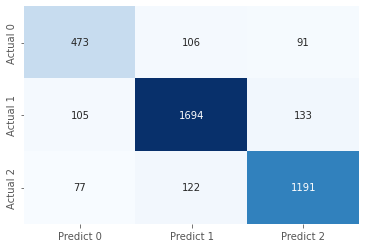

In [222]:
#Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)

matrix = pd.DataFrame(data =cm, columns=["Predict 0","Predict 1","Predict 2"],
                     index = ["Actual 0","Actual 1","Actual 2"])

conf_matrix = sns.heatmap(data = matrix, annot=True, cbar=False,fmt="d", cmap=plt.cm.Blues) 

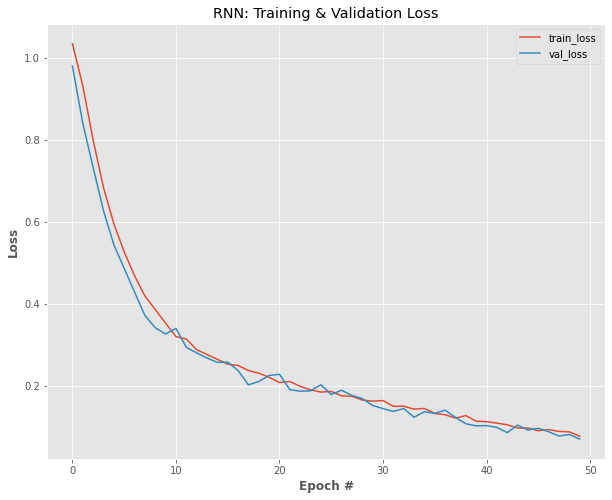

In [223]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, result.history["loss"], label="train_loss")
plt.plot(N, result.history["val_loss"], label="val_loss")
plt.title("RNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

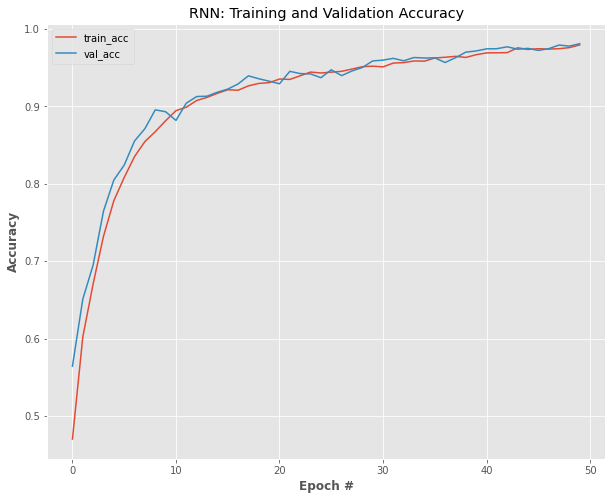

In [224]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, result.history["accuracy"], label="train_acc")
plt.plot(N, result.history["val_accuracy"], label="val_acc")
plt.title("RNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

In [225]:
#checking the current working directory
!dir

tweets_test.csv  tweets_train.csv


In [226]:
#load the test dataset
df_test = pd.read_csv("tweets_test.csv")
df_test.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source,is_retweet,clean_text
0,Doug Webb,Probably Europe,"I develop methods for effective cooperation, w...",2015-12-12 15:22:58,157,228,496,False,2020-09-15 22:53:36,"['theSocialDilemma', 'joinMastodon']",Twitter Web App,False,Watch theSocialDilemma then joinMastodon
1,Dan Reynish,"Medicine Hat, Alberta",News Anchor at Noon and 5 pm on CHAT TV. Canad...,2011-09-10 12:17:10,1722,2500,13912,False,2020-09-12 04:43:03,['WeTheNorth'],Twitter Web App,False,With the 2019 2020 NBA season officially over ...
2,🌤,NaN,NaN,2011-06-01 02:23:57,880,585,205,False,2020-09-19 07:06:53,['TheSocialDilemma'],Twitter for iPhone,False,if you want to really know about people go tal...
3,“IT IS WHAT IT IS.”🇰🇪🇳🇿🇺🇸,WA,Heliophile🌞☀️• #Rugby • Wildlifer • #HIV • #So...,2009-04-17 13:35:02,1143,2692,11999,False,2020-09-12 18:28:18,"['TheSocialDilemma', 'Netflix']",Twitter for iPhone,False,Have you watched TheSocialDilemma on Netflix
4,Mahima Sood,NaN,Amy Dunne X Holly Golightly || Data Scientist ...,2018-01-26 21:57:22,18,65,263,False,2020-09-12 18:48:53,['TheSocialDilemma'],Twitter for iPhone,False,Highly recommend TheSocialDilemma on


In [227]:
# creating the dataframe of the test dataset
df_test = df_test.clean_text
df_test = pd.DataFrame(df_test, columns=["clean_text"])
df_test

,clean_text
0,Watch theSocialDilemma then joinMastodon
1,With the 2019 2020 NBA season officially over ...
2,if you want to really know about people go tal...
3,Have you watched TheSocialDilemma on Netflix
4,Highly recommend TheSocialDilemma on
...,...
3063,Everybody should watch TheSocialDilemma
3064,Enjoyed TheSocialDilemma Then read this
3065,Couldn t stop thinking about docu TheSocialDil...
3066,This was the best one by on TheSocialDilemma on


In [228]:
#drop the null vaulues
df_test = df_test.dropna()

In [229]:
#Assigning the labels on the unseen data
sample_text = df_test["clean_text"][2]

prediction = rnn.predict(np.array([sample_text]))
pred=[np.argmax(i) for i in prediction]
if np.argmax(prediction) == 0:
    print("Negative")
elif np.argmax(prediction) == 1:
    print("Positive")
else:
    print("Neutral")
pred

Positive


[1]

**STEP8 - MAKING PREDICTION ON UNSEEN DATA**

In [230]:
#Making the prediction on the unseen data
y_pred = rnn.predict(np.array(df_test["clean_text"]))
y_pred[:10]

array([[5.68874297e-04, 8.48949421e-04, 9.98582244e-01],
       [3.79165769e-01, 2.57483032e-02, 5.95085859e-01],
       [2.30608450e-04, 9.99769151e-01, 1.90041789e-07],
       [4.62552393e-03, 1.40765775e-02, 9.81297851e-01],
       [1.10107269e-02, 9.88714993e-01, 2.74254358e-04],
       [5.77011220e-02, 9.40144002e-01, 2.15481198e-03],
       [4.61323140e-03, 2.39350259e-01, 7.56036520e-01],
       [1.53868692e-04, 1.15944204e-06, 9.99844909e-01],
       [1.22888768e-02, 9.87174034e-01, 5.37067594e-04],
       [2.16776673e-02, 9.75360811e-01, 2.96160439e-03]], dtype=float32)

In [231]:
# create new column for prediction on 3 label
df_test["Predicted_label"] = np.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [232]:
#Assigned the predicted values to unseen tweets(Test data)
df_test.head()

,clean_text,Predicted_label
0,Watch theSocialDilemma then joinMastodon,2
1,With the 2019 2020 NBA season officially over ...,2
2,if you want to really know about people go tal...,1
3,Have you watched TheSocialDilemma on Netflix,2
4,Highly recommend TheSocialDilemma on,1


In [233]:
#Creating a dictionary and assigning Sentiments to the labels
sentiments = {0:"Negative",1:"Positive",2:"Neutral"}
df_test["Sentiment"] = df_test["Predicted_label"].map(sentiments)
df_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,clean_text,Predicted_label,Sentiment
0,Watch theSocialDilemma then joinMastodon,2,Neutral
1,With the 2019 2020 NBA season officially over ...,2,Neutral
2,if you want to really know about people go tal...,1,Positive
3,Have you watched TheSocialDilemma on Netflix,2,Neutral
4,Highly recommend TheSocialDilemma on,1,Positive
...,...,...,...
3063,Everybody should watch TheSocialDilemma,2,Neutral
3064,Enjoyed TheSocialDilemma Then read this,2,Neutral
3065,Couldn t stop thinking about docu TheSocialDil...,0,Negative
3066,This was the best one by on TheSocialDilemma on,1,Positive


**STEP9 - VISUALIZING THE DISTRIBUTION OF SENTIMENT ON UNSEEN DATA**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


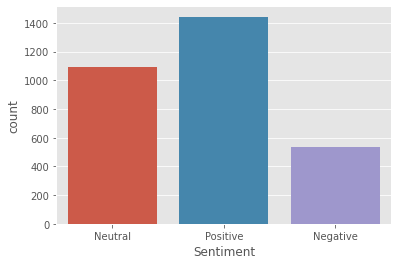

In [237]:
sns.countplot(df_test["Sentiment"])
plt.show()

**STEP10 - CONCLUSION**

Hence we can conclude the accuracy of our Model is 84% approx

          precision    recall  f1-score   support

           0       0.72      0.71      0.71       670
           1       0.88      0.88      0.88      1932
           2       0.84      0.86      0.85      1390

    accuracy                           84%      